In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
import readdata
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import os.path
from scipy import misc
import cv2
from progress_bar import ProgressBar
import shapefeatures
from sklearn import ensemble

Populating the interactive namespace from numpy and matplotlib


In [2]:
opts = {'img_dir': '../cells/plasmodium-phonecamera/',
        'models_dir': '../models/',
        'annotation_dir': '../cells/plasmodium-phonecamera/',
        'detection_probability_threshold': 0.5,
        'detection_overlap_threshold': 0.3, 
        'gauss': 1,
        'patch_size': (40,40),
        'image_downsample' : 2,
        'detection_step': 5,
        'patch_creation_step': 40,
        'object_class': None,
        'negative_training_discard_rate': .9
       }
opts['patch_stride_training'] = int(opts['patch_size'][0]*.25)

In [7]:
trainfiles, valfiles, testfiles = readdata.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.5,
                                                  val_set_proportion=0)

train_y, train_X = readdata.create_patches(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=False, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])
test_y, test_X = readdata.create_patches(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=False, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])

count=0
count1=0
for i in train_y:
    if i==1:
        count+=1
    else:
        count1+=1

print (count)
print (count1)

print (count1+count)
print (train_y.shape)


# Cut down on disproportionately large numbers of negative patches
train_X, train_y = readdata.balance(train_X, train_y, mult_neg=200)


count=0
count1=0
for i in train_y:
    if i==1:
        count+=1
    else:
        count1+=1

print (count)
print (count1)

print (count1+count)
print (train_y.shape)

# Create rotated and flipped versions of the positive patches
train_X, train_y = readdata.augment_positives(train_X, train_y)
test_X, test_y = readdata.augment_positives(test_X, test_y)
count=0
count1=0
for i in train_y:
    if i==1:
        count+=1
    else:
        count1+=1

print (count)
print (count1)

print (count1+count)
print (train_y.shape)
#print '\n'
# print '%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))
# print '%d positive testing examples, %d negative testing examples' % (sum(test_y), len(test_y)-sum(test_y))
# print '%d patches (%.1f%% positive)' % (len(train_y)+len(test_y), 100.*((sum(train_y)+sum(test_y))/(len(train_y)+len(test_y))))

3622
260117
263739
(263739,)
3622
260117
263739
(263739,)
28976
260117
289093
(289093,)


View a random selection of positive and negative patches to see if they look right

In [4]:
29416./261345

0.11255619965945397

In [5]:
count=0
count1=0
for i in train_y:
    if i==1:
        count+=1
    else:
        count1+=1

print (count)
print (count1)

print (count1+count)
print (train_y.shape)

28976
260450
289426
(289426,)


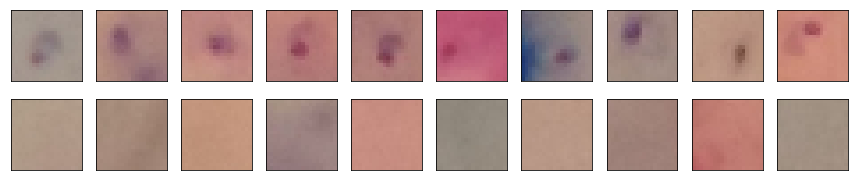

In [8]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

### CNN training

In [14]:
cnn.save_weights_to('3C_2FC_50EP_3C_v2.h5')

In [9]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv3', layers.Conv2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool2_pool_size=(2, 2),
        
    conv3_num_filters=12, 
    conv3_filter_size=(2, 2),    
    conv3_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden4_num_units=500,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(50).fit(train_X, train_y)

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f20fe0397f0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/gof/opt.py", line 85, in optimize
    self.add_requirements(fgraph)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/tensor/opt.py", line 1438, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/gof/fg.py", line 621, in attach_feature
    attach(self)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/tensor/opt.py", line 1262, in on_attach
    self.on_import(fgraph, node, reason='on_attach')
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/tensor/opt.py", line 1315,

# Neural Network with 56634 learnable parameters

## Layer information

  #  name     size
---  -------  -----------
  0  input    3x20.0x20.0
  1  conv1    7x18.0x18.0
  2  pool1    7x9.0x9.0
  3  conv2    12x8.0x8.0
  4  pool2    12x4.0x4.0
  5  conv3    12x3.0x3.0
  6  hidden4  500
  7  output   2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.09305     0.06199    1.50090      0.97945  52.10s
      2     0.05515     0.04905    1.12433      0.98328  52.13s
      3     0.04638     0.04307    1.07675      0.98487  52.14s
      4     0.04128     0.03719    1.11016      0.98686  52.10s
      5     0.03790     0.03436    1.10279      0.98789  52.25s
      6     0.03582     0.03265    1.09731      0.98853  52.34s
      7     0.03432     0.03151    1.08896      0.98886  52.36s
      8     0.03307     0.03059    1.08086      0.98916  52.37s
      9     0.03203     0.03008    1.06482      0.98938  52.

### Make predictions and evaluate on test data

In [10]:
y_pred = cnn.predict_proba(test_X)

In [11]:
pp=np.round(y_pred)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

#plt.savefig('figs/plasmodium-patchevaluation.png', bbox_inches='tight')

In [ ]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
true_positive_rate.shape, thresholds.shape
plt.plot(true_positive_rate, thresholds,label='True positive rate')
plt.plot(false_positive_rate, thresholds, label='False positive rate')
plt.xlabel('Threshold')
plt.legend(loc='upper left')

**Examine mistakes to understand network performance: false positives.** 

Find the negative-labelled patches with highest prediction score

In [ ]:
test_y.shape

True Negative -  1151
False Positve -  1184
-----------------------
Total Error -  2335


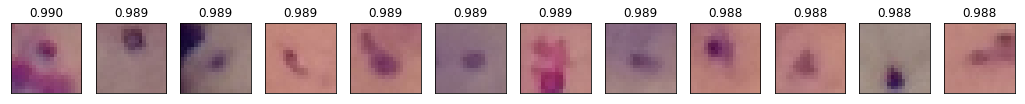

In [12]:
neg_indices = np.where(test_y==0)[0]
pos_indices = np.where(test_y==1)[0]


count=0
for p in pp[neg_indices,1]:
    if p==1:
        count+=1 

print ('True Negative - ',count)


count1=0
for p in pp[pos_indices,1]:
    if p==0:
        count1+=1 
        
print ('False Positve - ',count1)
print ('-----------------------')
print ('Total Error - ',count+count1)


neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]


N_samples_to_display = 12
offset = 55
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % neg_scores[i+offset])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('plasmodium-falsedetections.png', bbox_inches='tight')

See highest-scored test patches

In [ ]:
prob_range = [.95,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 12
offset = 0
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (tmp_scores[pos_indices[i+offset]]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('plasmodium-detectedpatches.png', bbox_inches='tight')

See lowest scored test patches

In [ ]:
pos_indices = y_pred[:,1].argsort()

N_samples_to_display = 12

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (y_pred[pos_indices[i],1]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('plasmodium-testpatches-lowprob.png', bbox_inches='tight')

### Example of objects detected in an entire image

The white boxes represent annotations in the training data. Red boxes are detections by the convnet.

In [13]:
from sklearn.metrics import accuracy_score
import pandas as pd
df=pd.DataFrame(y_pred)
pre=df.idxmax(axis=1)
print (pre.shape)
print (test_y.shape)

print (accuracy_score(test_y,pre))

(290523,)
(290523,)
0.99196277059


In [ ]:
import importlib
importlib.reload(det)

fname = testfiles[50]
imfile = opts['img_dir'] + fname
opts['detection_probability_threshold'] = 0.95

found = det.detect(imfile, cnn, opts)

im = misc.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

annofile = opts['annotation_dir'] + fname[:-3] + 'xml'
bboxes = readdata.get_bounding_boxes_for_single_image(annofile)
for bb in bboxes:
    bb = bb.astype(int)
    cv2.rectangle(im, (bb[0],bb[2]), (bb[1],bb[3]), (255,255,255), 2)  

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0],f[1]), (f[2],f[3]), (255,0,0), 2)

plt.gcf().set_size_inches(10,10)
print("{} Nos. of Parasites Found in the samples".format(len(found)))
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im)

#cv2.imwrite('detectionimages/detected-' + os.path.basename(imfile),im)

### Evaluation: compare with classification based on morphological feature extraction

In [ ]:
featureset = [3,7,11,12,15,17]
centiles = [0,25,50,75,100]

pb = ProgressBar(train_X.shape[0])
train_X_f = []
for i in range(train_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(train_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    train_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
train_X_f = np.vstack(train_X_f)

test_X_f = []
for i in range(test_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(test_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    test_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
test_X_f = np.vstack(test_X_f)

In [ ]:
clf = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(train_X_f, train_y)
y_pred_CLF = clf.predict_proba(test_X_f)

In [ ]:
false_positive_rate_CNN, true_positive_rate_CNN, thresholds_CNN = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc_CNN = metrics.auc(false_positive_rate_CNN, true_positive_rate_CNN)

precision_CNN, recall_CNN, thresholds_CNN = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision_CNN = metrics.average_precision_score(test_y, y_pred[:, 1])

false_positive_rate_CLF, true_positive_rate_CLF, thresholds_CLF = metrics.roc_curve(test_y, y_pred_CLF[:,1])
roc_auc_CLF = metrics.auc(false_positive_rate_CLF, true_positive_rate_CLF)

precision_CLF, recall_CLF, thresholds_CLF = metrics.precision_recall_curve(test_y, y_pred_CLF[:,1])
average_precision_CLF = metrics.average_precision_score(test_y, y_pred_CLF[:, 1])

subplot(211)
plt.title('ROC' )
plt.plot(false_positive_rate_CNN, true_positive_rate_CNN, 'b', label='CNN: AUC=%.2f' % (roc_auc_CNN))
plt.plot(false_positive_rate_CLF, true_positive_rate_CLF, 'k--', label='ERT: AUC=%.2f' % (roc_auc_CLF))
plt.legend(loc='lower right')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(212)
plt.plot(recall_CNN, precision_CNN, label='CNN: AP=%.2f' % (average_precision_CNN))
plt.plot(recall_CLF, precision_CLF,'k--', label='ERT: AP=%.2f' % (average_precision_CLF))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")

plt.gcf().set_size_inches(4,10)

plt.savefig('figs/plasmodium-phone-patchevaluation.png', bbox_inches='tight')

In [ ]:
for v in ['false_positive_rate_CNN','true_positive_rate_CNN','false_positive_rate_CLF',
 'true_positive_rate_CLF','roc_auc_CNN','roc_auc_CLF','recall_CNN','precision_CNN',
 'average_precision_CNN','recall_CLF','precision_CLF','average_precision_CLF']:
    print '"%s": %s,' % (v,v)

In [ ]:
results = {
"false_positive_rate_CNN": false_positive_rate_CNN,
"true_positive_rate_CNN": true_positive_rate_CNN,
"false_positive_rate_CLF": false_positive_rate_CLF,
"true_positive_rate_CLF": true_positive_rate_CLF,
"roc_auc_CNN": roc_auc_CNN,
"roc_auc_CLF": roc_auc_CLF,
"recall_CNN": recall_CNN,
"precision_CNN": precision_CNN,
"average_precision_CNN": average_precision_CNN,
"recall_CLF": recall_CLF,
"precision_CLF": precision_CLF,
"average_precision_CLF": average_precision_CLF,
"opts": opts
}
import pickle
pickle.dump(results,open('plasmodium-phone-results.pkl','w'))